# A/B-тестирование.

---
__Цель настоящей работы - выполнить анализ последствий внедрения новой рекомендательной системы на сайте международного интернет-магазина.__  
    
   __В процессе анализа будут выполнены следующие действия.__

 - Предварительный анализ качества исходных данных.
 - Проверка данных на корректность и их необходимые изменения.   
 - Исследовательский анализ данных и проверка статистических гипотез.
 - Оценка результатов проведенного А/В-тестирования.
 - Формулировка выводов.
 
 __В работе необходимо:__
 

   - Решить требуется ли преобразование типов.
   - Проверить присутствуют ли пропуски и дубликаты
   - Исследовать  конверсию в воронке на разных этапах.
   - Понять обладают ли выборки одинаковыми распределениями количества событий на пользователя.
   - Определить присутствуют ли в выборках одни и те же пользователи.
   - Выяснить как число событий распределено по дням.
   - Понять есть ли какие-либо особенности в данных, которые нужно учесть, прежде чем приступить к тестированию.
   - Сформулировать выводы по А/А-тестированию.
   - Проверить статистическую разницу долей z-критерием.
   - Описать выводы по этапу исследовательского анализа данных и по оценке результатоа А/В-тестирования.
   


---


---

## Загрузка модулей и файлов с исходными данными

In [158]:
# загрузка модулей
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt, seaborn as sns, pylab as pl
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats as st
import math as mth
import random

In [159]:
# загрузка исходных данных
m_events = pd.read_csv('ab_project_marketing_events.csv')
events = pd.read_csv('final_ab_events.csv')
new_users = pd.read_csv('final_ab_new_users.csv')
particip = pd.read_csv('final_ab_participants.csv')

In [160]:
events_c = events.copy(deep=True)
new_users_c = events.copy(deep=True)
particip_c = particip.copy(deep=True)

## Проверка исходных данных

In [161]:
m_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [162]:
m_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [163]:
# изменение формата данных времени для обеспечения дальнейших вычислений
m_events['start_dt'] = m_events['start_dt'].astype('datetime64[s]')
m_events['finish_dt'] = m_events['finish_dt'].astype('datetime64[s]')

In [164]:
m_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [165]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [166]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [167]:
# уникальные значения типов событий
events.event_name.unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [168]:
# изменение формата времени с целью обеспечения дальнейших вычислений
events['event_dt'] = events['event_dt'].astype('datetime64[s]')
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [169]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [170]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [171]:
# уникальные значения категории региона
new_users.region.unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [172]:
# уникальные значения типа устройств пользователей
new_users.device.unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [173]:
particip.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [174]:
particip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [175]:
# типы тестов
particip.ab_test.unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [176]:
# наименования групп пользователей
particip.group.unique()

array(['A', 'B'], dtype=object)

In [177]:
# проверка пропусков в данных
m_events.isnull().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [178]:
# проверка пропусков в данных
events.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [179]:
# проверка пропусков в данных
new_users.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [180]:
# проверка пропусков в данных
particip.isnull().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [181]:
# проверка дублированных данных
print(m_events.duplicated().sum())
print(events.duplicated().sum())
print(new_users.duplicated().sum())
print(particip.duplicated().sum())

0
0
0
0


---
__Исходные данные расположены в 4 файлах и после загрузки сформировали соответственно 4 датафрейма. Следующие таблицы содержат сведения, описанные в техническом задании:__

 - __*m_events*__: сведения о маркетинговых мероприятиях в регионах с указанием времени их проведения
 - __*events*__:  сведения о событиях в приложении, созданные пользователями в период проведения теста
 - __*new_users*__: сведения о пользователях, зарегистрированных в интернет-магазине в период проведения теста
 - __*particip*__: данные об участниках тестов.

__Первичный анализ данных показал, что пропущенных значений нет, как нет и дублированных записей. Понадобилось преобразование типа данных о времени.__

__В целом данные качественные. Однако требуется их дальнейшая проверка на предмет правильности их формирования для целей АВ-теста.__  

---

## Исследовательский анализ данных.

---
__В настоящем разделе проведен анализ данных, предваряющий проведение АВ-тестирование. Сначала данные проверяются на правильность их формирования для тестов. К таким проверкам относятся:__

 - проверка на пересечение пользователей в группах
 - проверка на соответствие заявленным регионам присутствия пользователей
 - проверка на соответствие периоду проведения тестов
 - проверка на отсутствие маркетинговых мероприятий, стимулирующих активность пользователей в период проведения теста
 
__Дополнительно могут проведены и иные оценки и расчеты.__

---

In [182]:
# количество уникальных пользователей в таблице участников тестов
particip.user_id.nunique()

16666

In [183]:
# количество уникальных пользователей среди всех, зарегистрированных с 7 по 21 декабря 2020 
new_users.user_id.nunique()

61733

In [184]:
# количество уникальных пользователей в таблице событий новых пользователей в период с 7 декабря 2020 по 4 января 2021 
events.user_id.nunique()

58703

In [185]:
# количество пользователей по группам А и В без учета типа теста
particip_grp_group = particip.groupby('group').agg({'user_id':'nunique'})
particip_grp_group.head()

,user_id
group,
A,9173
B,8269


In [186]:
# количество пользователей по видам теста 
particip_grp_group = particip.groupby(['ab_test']).agg({'user_id':'nunique'})
particip_grp_group.head()

,user_id
ab_test,
interface_eu_test,11567
recommender_system_test,6701


In [187]:
# количество пользователей по видам теста и группам А и В
particip_grp_group = particip.groupby(['ab_test','group']).agg({'user_id':'nunique'})
particip_grp_group.head()

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

In [188]:
# количество пользователей по регионам
new_users_grp_region = new_users.groupby('region').agg({'user_id':'nunique'})
new_users_grp_region.head(10)

,user_id
region,
APAC,3153
CIS,3155
EU,46270
N.America,9155


---
__По общим данным видно, что количество пользователей примерно одинаковое, что важно для проведения теста. Более важно, что число пользователей в группах А и В  теста recommender_system_test достаточно сбалансировано. Общее количество пользователей в этой группе теста - 6701. Эта группа теста будет использована для анализа и проведения АВ=теста в дальнейшем.__

__Самое большое количество пользователей из региона Европы - 4627. Именно эти пользователи должны использоваться для АВ-тестирования.__

---

#### Проверка дублирования пользователей в группах А и В  одного типа теста

In [189]:
# подготовка срезов по видам теста
particip_sys = particip.query('ab_test == "recommender_system_test"')
particip_eu = particip.query('ab_test == "interface_eu_test"')

In [190]:
# общие сведения о численности в таблице об участниках теста
print(particip.shape[0])
print(particip.user_id.nunique())

18268
16666


In [191]:
# проверка пересечения пользователей по группам А и В в общих данных 
particip_grp = (particip
                .groupby(['user_id','ab_test'])
                .agg(n_group=('group','nunique')).sort_values(by='n_group', ascending=False)
                .query('n_group > 1')
               )
particip_grp.shape[0]

0

In [192]:
# проверка пересечения пользователей по группам А и В в данных по тесту recommender_system_test
particip_sys_grp = (particip_sys
                   .groupby(['user_id'])
                   .agg(n_group=('group','nunique')).sort_values(by='n_group', ascending=False)
                   )
particip_sys_grp.query('n_group > 1').shape[0]

0

In [193]:
# дополнительная проверка пересечения пользователей по группам А и В в данных по тесту interface_eu_test (опционально)
particip_eu_grp = (particip_eu
                   .groupby(['user_id'])
                   .agg(n_group=('group','nunique')).sort_values(by='n_group', ascending=False)
                  )
particip_eu_grp.query('n_group > 1').shape[0]

0

---
__Проверка показала, что пересечений между группами А и В в их группе типа теста нет. Нужно проверить присутствие пользователей из групп с другим типом теста.__

---

#### Проверка пересечения пользователей из разных типов тестов

In [194]:
# подготовка срезов по группам А и В
participA = particip.query('group == "A"')
participB = particip.query('group == "B"')

In [195]:
# проверка пересечения по общим данным
particip_grp = (particip
                .groupby(['user_id', 'group'])
                .agg(n_abtest=('ab_test','nunique')).sort_values(by='n_abtest', ascending=False)
               )
particip_grp.query('n_abtest > 1').shape[0]

826

In [196]:
# проверка присутствия пользователей из других типов теста в группе А 
participA_grp = (participA
                 .groupby(['user_id','group'])
                 .agg(n_abtest=('ab_test','nunique')).sort_values(by='n_abtest', ascending=False)
                )
participA_grp.query('n_abtest > 1').shape[0]

482

In [197]:
# проверка присутствия пользователей из других типов теста в группе В 
participB_grp = (participB
                 .groupby(['user_id','group'])
                 .agg(n_abtest=('ab_test','nunique')).sort_values(by='n_abtest', ascending=False)
                )
participB_grp.query('n_abtest > 1').shape[0]

344

---
__К сожалению, обнаружено присутствие пользователей из других типов теста. В дальнейшем для исследовательского анализа таких пользователей можно оставить, но на этапе анализа АВ-тестирования их рекомендуется удалить, при условии, что такое пересечение пользователей будет обнаружено в данных участников группы recommender_system_test.__ 

---

#### Проверка количества пользователей из региона EU, зарегистрировавщихся в период с 7 по 21 включительно 2020 г.

In [198]:
# определение количества пользователей региона EU, всего в таблице new_users
n = new_users.query('region == "EU"')
n.shape[0]

46270

In [199]:
# проверка количества пользователей, зарегистрировавщихся в период с 7 по 21 декабря включительно 2020 г.
first_date = datetime(2020,12,7).strftime('%Y-%m-%d')
last_date = datetime(2020,12,21).strftime('%Y-%m-%d')

users = new_users.query('region == "EU" and first_date >= @first_date and first_date <= @last_date')
users.shape[0]

42340

In [200]:
# вычисление доли пользователей из Европы, но зарегистрированных вне периода набора новых пользователей
(print('Процент пользователей региона EU, зарегистрированных вне периода набора новых пользователей: {:.1%}'
       .format((n.shape[0]-users.shape[0]) / users.shape[0]))
)

Процент пользователей региона EU, зарегистрированных вне периода набора новых пользователей: 9.3%


---
__Число пользователей, зафиксированных как новые и расположенных в таблице new_users больше числа пользователей зарегистрировавшихся в установленный техническим заданием период регистрации - с 7 по 21 декабря 2020 г. Такое превышение составило 9.3% от числа зарегистрированных вовремя.__

__Удаление таких пользователей, возможно, не обязательно.__

---

#### Проверка доли пользователей из региона EU

---
__Ниже представлен расчет процента пользователей из региона Европы, которые в соответствии с ТЗ должны быть  участниками тестирования и их доля должна составить 15% новых пользователей из этого же региона. Необходимо проверить что уже подготовленная группа теста recommender_system_test соответствует этим требованиям.__

---

In [201]:
# подготовка срезов по тесту recommender_system_test и по новым пользователям из Европы
particip_recommend = particip.query('ab_test == "recommender_system_test"')
users = new_users.query('region == "EU" and first_date >= @first_date and first_date <= @last_date')

In [202]:
# объединение таблиц
test = pd.merge(particip_recommend, users, on='user_id', how='inner')
test.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [203]:
# вычисление доли пользователей теста recommender_system_test от числа новых пользователей из Европы
round((particip_recommend.shape[0] / users.shape[0] *100), 1)

15.8

In [204]:
# определение доли пользователей из региона EU, вовремя зарегистрированных, входящих в recommend_system_test,
# от общего числа новых пользователей из Европы   
test.shape[0] / users.shape[0] *100

15.0

---
__Вычисления говорят о том, что уже подготовленная группа recommend_system_test, вполне удовлетворяет требованиям ТЗ и может быть использована для подготовки и проведения АВ-тестирования.__

---

#### Проверка факта проведения маркетинговых мероприятий в период теста  

In [205]:
# проверка наличия маркетинговых, праздничных мероприятий, совпадающих по времени с проведением теста.
start = datetime(2020,12,7).strftime('%Y-%m-%d')
finish = datetime(2021,1,4).strftime('%Y-%m-%d')
m_events_f = m_events.query('start_dt >= @start and finish_dt < @finish')
m_events_f.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


---
__Проверка опрделила наличие рождественских мероприятий, совпадающих по времени с проведением теста. Это означает, что повышенная праздничная промо-программа может исказить данные пользовательской активности, замеряемой в тесте.__

__Данное обстоятельство необходимо учесть в выводах.__



---

---
__Общий итог проведенных проверок и вычислений таков.__

 - Данные содержат пересечение пользователей из разных типов теста
 - Данные содержать присутствие пользователей из других регионов
 - Присутствуют пользователи, зарегистрированные позже установленного срока
 - На период проведения теста приходится праздничное мероприятие
__Перечисленное характеризует выполненную работу по подготовке данных как неудовлетворительную.__

__В такой ситуации необходимо было бы выделить дополнительное время для качественного завершения работ. Возможно, что такое решение и примет руководство проекта. Однако это не мешает провести дальнейший анализ, чтобы посмотреть на те результаты и тренды, которые могут быть в дальнейшем подтверждены и уточнены более качественным тестированием.__ 
 

---

### Исследование общих данных без учета групп

---
>__Необходимо обратить внимание на то, что анализ в разделе будет проводится по данным, которые еще не скорректированы, в соответствии с сформулированными ранее проблемами в данных. Это будет сделано на этапе проведения АВ-тестирования.__

---

#### Подготовка функционала для упрощения дальнейших вычислений  

In [206]:
# функция расчета воронок первого типа
def funnel(df):
    p = df.pivot_table(index='user_id', columns='event_name', values='event_dt', aggfunc='min')
    p.columns = ['login', 'cart', 'page', 'purchase']
    p = p[['login','page','cart','purchase']]
    # расчет последовательности прохождения пользователей по маршруту воронки 
    step1 = ~p.login.isna()
    step2 = step1 & (p.page > p.login)
    step3 = step2 & (p.cart > p.page)
    step4 = step3 & (p.purchase > p.cart)
    # подсчет кол-ва пользователей, проявивших активность на разных этапах
    n_login = p[step1].shape[0]
    n_page = p[step2].shape[0]
    n_cart = p[step3].shape[0]
    n_purchase = p[step4].shape[0]
    # итоговые данные по воронке событий
    print('Посетителей:', n_login) 
    print('Ознакомились с предложением:', n_page,', что составляет {:.1%} от числа посетителей'.format(n_page / n_login))
    print('Положили в корзину:', n_cart,', что составляет {:.1%} от числа ознакомившихся с предложением'.format(n_cart / n_page))
    print('Оплатили:', n_purchase,', что составляет {:.1%} от числа положивших в корзину'.format(n_purchase / n_cart))
    # возврат списка рассчитаных значений
    return [n_login, n_page, n_cart, n_purchase]

In [207]:
# график воронки событий по стадиям "посетили гл. страницу-ознакомились с предложением-положили в корзину-оплатили"
def funnel_plot(df):
    layout = go.Layout(title='Воронка событий по стадиям "посетили-ознакомились-положили в корзину-оплатили"')
    fig = go.Figure(go.Funnel(
                          y=['Посетителей', 'Ознакомились с предложением', 'Положили в корзину', 'Оплатили'],
                          x=funnel(df),
                          #text=["Посетителей","Ознакомились с предложением","Положили в корзину","Оплатили"],
                          textposition="outside",
                          textinfo = "value+percent previous"),
                          layout=layout
                   )
    fig.show()

In [208]:
# функция расчета воронок второго типа
def funnel2(df):
    grp = (df.groupby('event_name')
             .agg({'user_id':'nunique'})
             .pivot_table(columns='event_name')
      )
    grp = grp.rename(columns={"product_cart": "cart", "product_page": "page"})
    grp = grp[['login','page','cart','purchase']]
    return [grp.loc['user_id','login'], grp.loc['user_id','page'], grp.loc['user_id','cart'], grp.loc['user_id','purchase']]
    #return grp.values #.tolist()

In [209]:
# график воронки событий по стадиям "посетили гл. страницу-ознакомились с предложением-положили в корзину-оплатили"
def funnel_plot2(df):
    layout = go.Layout(title='Воронка событий по стадиям "посетили-ознакомились-положили в корзину-оплатили"')
    fig = go.Figure(go.Funnel(
                          y=['Посетителей', 'Ознакомились с предложением', 'Положили в корзину', 'Оплатили'],
                          x=funnel2(df),
                          #text=["Посетителей","Ознакомились с предложением","Положили в корзину","Оплатили"],
                          textposition="inside",
                          textinfo = "value+percent previous"),
                          layout=layout
                   )
    fig.show()


#### Распределение числа событий по дням

In [210]:
#edge_date = datetime(2020,12,24).strftime('%Y-%m-%d')
#data = data_all.query('event_dt < @edge_date')

[Text(0, 0, '2020-12-03 12:53:20'),
 Text(0, 0, '2020-12-09 07:46:40'),
 Text(0, 0, '2020-12-15 02:40:00'),
 Text(0, 0, '2020-12-20 21:33:20'),
 Text(0, 0, '2020-12-26 16:26:40'),
 Text(0, 0, '2021-01-01 11:20:00')]

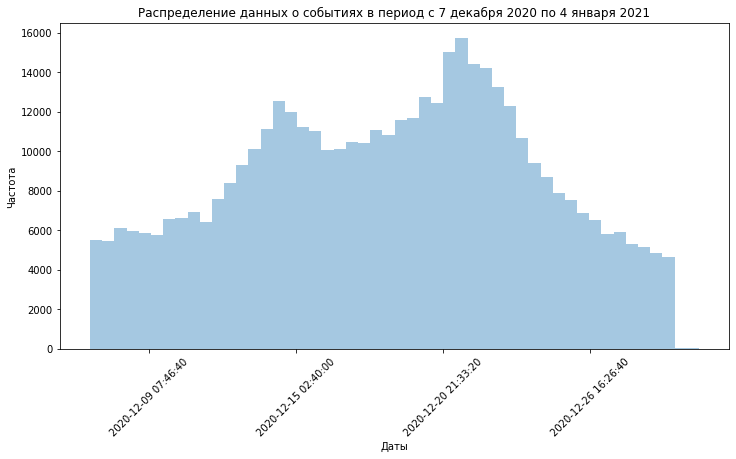

In [211]:
# гистограмма распределения событий в период августа 2019 после отсечения неполных данных за июль
plt.figure(figsize=(12,6))
d = events.event_dt.astype(np.int64)
ax = sns.distplot(d, kde=False)
ax.set_title('Распределение данных о событиях в период с 7 декабря 2020 по 4 января 2021')
ax.set_xlabel('Даты')
ax.set_ylabel('Частота')
labels = ax.get_xticks().tolist()
labels = pd.to_datetime(labels)
ax.set_xticklabels(labels, rotation=45)

---
__Число событий, распределенное по дням, показывает 2 характерных пика в области 15 и 21 декабря, с плавным ростом от начала измерений и таким же плавным спадом активности к 25 декабря, т.е. к начулу рождественных праздников в Европе. Наиболее активный период- 12-26 декабря - характерное время подарков и отложенных на конец года приобретений.__

__За весь период зарегистрировано более 440 тыс.  событий в приложении.__

---

### Исследование конверсии в воронке на разных этапах 

---
>__Необходимо обратить внимание на то, что анализ в разделе будет проводится по данным, которые еще не скорректированы, в соответствии с сформулированными ранее проблемами в данных. Это будет сделано на этапе проведения АВ-тестирования.__

---

---
__Для определения характера поведения конверсии на разных этапах воронки будем использовать графики funnel из библиотеки plotly.express.__

> *Примечание*. Необходимо учесть, что графики funnel отображают сведения о доле показателя не только от предыдущего этапа, но и начального этапа. 

__Для просмотра показателей воронки нужно использовать интерактивность графиков, размещая курсор на различные этапы.__

---

---
__Воронка событий без разделения на группы А и В__

---

In [212]:
#
funnel_plot2(events)

---
__Видно, что конверсия в покупки, по общим данным довольно высока - 33%. Это хороший показатель.__

---

### Исследование данных по группам А и В

In [213]:
# подготовка данных для анализа поведения активности по группа А и В
events_part = pd.merge(particip, events, on='user_id', how='inner')
events_part.head()

,user_id,group,ab_test,event_dt,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN


In [214]:
# подготовка данных для анализа 
events_part_A = events_part.query('group == "A"')
events_part_B = events_part.query('group == "B"')
print(events_part_A.shape[0])
print(events_part_B.shape[0])

60874
45751


[Text(0, 0, '2020-12-03 12:53:20'),
 Text(0, 0, '2020-12-09 07:46:40'),
 Text(0, 0, '2020-12-15 02:40:00'),
 Text(0, 0, '2020-12-20 21:33:20'),
 Text(0, 0, '2020-12-26 16:26:40'),
 Text(0, 0, '2021-01-01 11:20:00')]

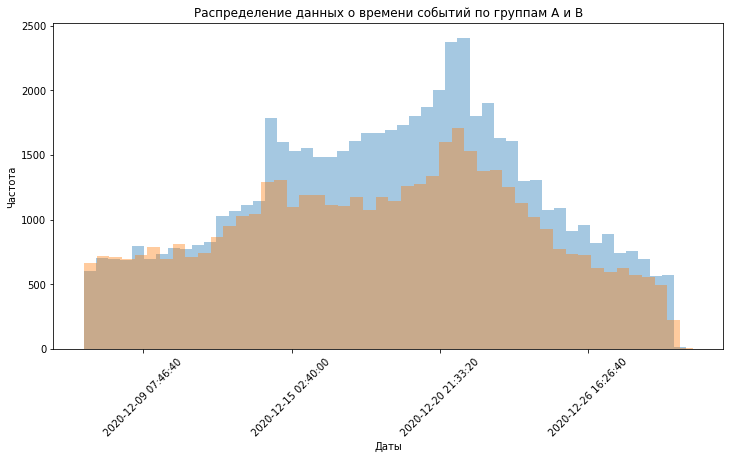

In [215]:
# гистограмма распределения событий по группам А и В 
plt.figure(figsize=(12,6))
d1 = events_part_A.event_dt.astype(np.int64)
d2 = events_part_B.event_dt.astype(np.int64)
ax = sns.distplot(d1, kde=False)
ax = sns.distplot(d2, kde=False)
ax.set_title('Распределение данных о времени событий по группам А и В')
ax.set_xlabel('Даты')
ax.set_ylabel('Частота')
labels = ax.get_xticks().tolist()
labels = pd.to_datetime(labels)
ax.set_xticklabels(labels, rotation=45)

In [216]:
# описательная статистика по характеру распределения числа событий по группе А
events_part_A_grp = (events_part_A.groupby('user_id')
                     .agg(n_events=('event_dt','count')).sort_values(by='n_events', ascending=False)
                    )
events_part_A_grp.describe()

,n_events
count,7874.000000
mean,7.731013
std,4.607334
min,1.000000
25%,4.000000
50%,6.000000
75%,10.000000
max,40.000000


In [217]:
# описательная статистика по характеру распределения числа событий по группе В
events_part_B_grp = (events_part_B.groupby('user_id')
                     .agg(n_events=('event_dt','count')).sort_values(by='n_events', ascending=False)
                    )
events_part_B_grp.describe()

,n_events
count,6205.000000
mean,7.373247
std,4.343814
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,36.000000


---
__Выборки обладают практически одинаковыми статистическими значениями распределения количества событий на пользователя. Среднее значение количества событий на пользователя составляют для А и В соответственно 7.73 и 7.37. Максимальные значения 40 и 36 соответственно. Очень показательно, что медианные значения одинаковы и составляют 6 событий. Т.е. статистически распределения событий на пользователя в группах А и В очень близки.__

---

In [218]:
# воронка конверсии по группе А
funnel_plot2(events_part_A)

In [219]:
# воронка конверсии по группе В
funnel_plot2(events_part_B)

---
__Распределение событий по времени и по  группам А и В практически повторяет по форме общее распределение без учета разбиения на группы. Но есть и отличия. Заметно, что не только по числу событий различаются группы - группа А содержит большее число событий, но и характер относительных изменений на "краях" и в "средней" части гистограммы различен. Т.е., если в начале и в конце измерений активность пользователей практически одинакова, то в период выросшей праздничной активности, активность группы А заметно выше активности группы В. Вероятно, что этому способствуют изменения, выполненные для пользователей группы А. Необходимо проверить статистическую разницу долей z-тестом.__   

__Конверсия в покупки по группам весьма похожа и состовляет более 30%. Однако замечено, что в группе А число пользователей на этапе покупки превышает  число пользователей на предыдущем этапе. Скорее всего, это следствие ошибок в измерениях(точнее в доставке данных), а не изъян а приложении, когда можно купить не положив в корзину.__

---

### A/B-тестирование

__Подготовительные процедуры перед А/В-тестированием.__

---
__Прежде чем приступить к тестированию необходимо выполнить действия для проверки и, возможно, улучшения данных в выборках, с учетом выявленных ранее проблем в данных.__


--- 

In [220]:
# подготовка срезов с учетом пользователей recommender_system_test
test_particip = particip_c.query('ab_test == "recommender_system_test"')

#### Проверка присутствия пользователей из теста interface_eu_test


In [221]:
# подготовка данных 
test_participA = test_particip.query('group == "A"')
test_participB = test_particip.query('group == "B"')

In [222]:
# проверка на присутствие пользователей из другого теста
(test_particip.groupby(['user_id', 'group'])
              .agg(n_abtest=('ab_test','nunique')).sort_values(by='n_abtest', ascending=False)
              .query('n_abtest > 1')
              .shape[0])

0

In [223]:
# проверка на присутствие пользователей из другого теста в группе А
(test_participA.groupby(['user_id','group'])
               .agg(n_abtest=('ab_test','nunique'))
               .query('n_abtest > 1')
               .shape[0])

0

In [224]:
# проверка на присутствие пользователей из другого теста в группе В
(test_participB.groupby(['user_id','group'])
               .agg(n_abtest=('ab_test','nunique'))
               .query('n_abtest > 1')
               .shape[0])

0

In [225]:
# объединение таблиц 
test_users = pd.merge(test_particip, new_users, on='user_id', how='inner')
test_users.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


---
__В группе теста recommender_system_test нет пользователей из другой группы__

---

In [226]:
# проверка на присутствие пользователей из других регионов
region_not_EU = test_users.query('region != "EU"')
region_not_EU.head()


,user_id,group,ab_test,first_date,region,device
6351,800AF45A68291849,A,recommender_system_test,2020-12-07,N.America,Android
6352,8CB01194A7A8B2C6,B,recommender_system_test,2020-12-10,N.America,Android
6353,E93E75B64A774E02,B,recommender_system_test,2020-12-17,N.America,PC
6354,ECE67C0C773DCA8F,B,recommender_system_test,2020-12-09,N.America,Android
6355,01E9662F25EE4560,B,recommender_system_test,2020-12-17,CIS,PC


In [227]:
# кол-во пользователей из других регионов
region_not_EU.shape[0]

350

In [228]:
# формирование списка идентификаторов пользователей из других регионов
list_for_delete = region_not_EU.user_id.to_list()
print(len(list_for_delete))

350


In [229]:
# проверка количества пользователей, зарегистрировавщихся в период с 7 по 21 включительно 2020 г.
first_date = datetime(2020,12,7).strftime('%Y-%m-%d')
last_date = datetime(2020,12,21).strftime('%Y-%m-%d')

test_date = test_users.query('region == "EU" and first_date < @first_date and first_date > @last_date')
test_date.shape[0]

0

---
__Число пользователей из других регионов, попавших в данные для анализа составляет 350 человек.__

__Нет пользователей вне периода  времени, установленного для реформирования группы для тестирования.__ 

---

#### Удаление пользователей из других регионов

In [230]:
# удаление из списка пользователей для тестирования участников из других регионов
test_particip_corr = test_particip.query('user_id not in @list_for_delete')
test_particip_corr.shape[0]

6351

In [231]:
test_particip.shape[0]

6701

In [232]:
(print('Доля удаленных пользователей: {:.1%}'
       .format((test_particip.shape[0] - test_particip_corr.shape[0]) / test_particip.shape[0]))
)

Доля удаленных пользователей: 5.2%


---
__Доля пользователей удаленных из группы, участвующей в тесте, составила 5.2%__

---

In [233]:
# формирование объединенных таблиц с использованием корректированного перечня пользователей-участников теста
# new_user_c и events_c - "твердые" копии соответствующих исходных таблиц
test_new_users = pd.merge(new_users_c, test_particip_corr, on='user_id', how='left')
test_events = pd.merge(events_c, test_particip_corr, on='user_id', how='left')

#### Формирование таблицы для А/В-теста.

In [234]:
sample = test_events #sample = pd.merge(events, test_particip_corr, on='user_id', how='inner')
sample_A = sample.query('group == "A"')
sample_B = sample.query('group == "B"')

In [235]:
sample_A.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
login,2604
product_page,1685
purchase,833
product_cart,782


In [236]:
sample_B.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
event_name,
login,877
product_page,493
purchase,249
product_cart,244


---
__Заметен дисбаланс по численности групп А и В. На первом этапе "login" в группе А - 2604, а в группе B - 877 человек.__

---

In [237]:
funnel_plot2(sample_A)

In [238]:
funnel_plot2(sample_B)

---
__На графиках заметны те же аномалии на последних этапах и можно констатировать, что конверсия на разных этапах слабо изменилась после очистки  всех данных и мало отличается между группами А и В.__

__Следует сформулировать статистическую гипотезу и провести анализ на основе z-теста.__


---

#### Определение функций для расчета z-теста для различного применения

---
__Ниже представлены два типа функций для анализа: с учетом последовательности событий и без учета последовательности событий.__

__В настоящем проекте будем считать основным тест без учета последовательности событий, т.к. обнаружены заметные признаки того, что данные искажены и делать выводы о промежуточных конверсиях нужно осторожно. В то же время заключение о статистической значимости различий в итоговой конверсии можно попробовать для оценки.__ 

---

In [239]:
# функция для расчета конверсии числа событий на каждом этапе маршрута пользователя для двух сравниваемых выборок

def prop(df, df1, step): # df и df1 - имена выборок, step - имя этапа маршрута пользователя
                                 
    # расчет воронки и основных параметров для первой выборки
    df_pivot = df.pivot_table(index='user_id', columns='event_name', values='event_dt', aggfunc='min')
    df_pivot.columns = ['login', 'cart', 'page', 'purchase']
    step1 = ~df_pivot.login.isna()
    step2 = step1 & (df_pivot.page > df_pivot.login)
    step3 = step2 & (df_pivot.cart > df_pivot.page)
    step4 = step3 & (df_pivot.purchase > df_pivot.cart)

    n_login   = df_pivot[step1].shape[0]
    n_page = df_pivot[step2].shape[0]
    n_cart   = df_pivot[step3].shape[0]
    n_purchase = df_pivot[step4].shape[0]
    total_users = df['user_id'].nunique()
    
    p_login = n_login / total_users
    p_page = n_page / total_users
    p_cart = n_cart / total_users
    p_purchase = n_purchase / total_users
    
        
    
     # расчет воронки и основных параметров для второй  выборки
    df1_pivot = df1.pivot_table(index='user_id', columns='event_name', values='event_dt', aggfunc='min')
    df1_pivot.columns = ['login', 'cart', 'page', 'purchase']
    step11 = ~df1_pivot.login.isna()
    step21 = step11 & (df1_pivot.page > df1_pivot.login)
    step31 = step21 & (df1_pivot.cart > df1_pivot.page)
    step41 = step31 & (df1_pivot.purchase > df1_pivot.cart)

    n_login1   = df1_pivot[step11].shape[0]
    n_page1 = df1_pivot[step21].shape[0]
    n_cart1   = df1_pivot[step31].shape[0]
    n_purchase1 = df1_pivot[step41].shape[0]
    total_users1 = df1['user_id'].nunique()
    
    p_login1 = n_login1 / total_users1
    p_page1 = n_page1 / total_users1
    p_cart1 = n_cart1 / total_users1
    p_purchase1 = n_purchase1 / total_users1
    
    
    
    # возврат списка параметров для вычисления z-value, в зависимости от параметра step
    if step == 'login':
        p1 = p_login # значение p1 z-теста
        p2 = p_login1 # значение p2 z-теста
        p_comb = (n_login + n_login1) / (total_users + total_users1) # значение p-combined z-теста
        diff = p1 - p2  # значение difference z-теста
        return [p1, p2, p_comb, diff, total_users, total_users1] # возвращаемый список параметров для z-теста
    
    elif step == 'page':
        p1 = p_page
        p2 = p_page1
        p_comb = (n_page + n_page1) / (total_users + total_users1)
        diff = p1 - p2
        return [p1, p2, p_comb, diff, total_users, total_users1]
         
    elif step == 'cart':
        p1 = p_cart
        p2 = p_cart1
        p_comb = (n_cart + n_cart1) / (total_users + total_users1)
        diff = p1 - p2
        return [p1, p2, p_comb, diff, total_users, total_users1]
    
    elif step == 'purchase':
        p1 = p_purchase
        p2 = p_purchase1
        p_comb = (n_purchase + n_purchase1) / (total_users + total_users1)
        diff = p1 - p2
        return [p1, p2, p_comb, diff, total_users, total_users1] 
    
    else: return -1
    

In [240]:
# функция z-теста для вычисления статистической значимости различий в сравниваемых выборках

def ztest(df, df1, step, alpha): # df -имя первой выборки, df1- имя второй выборки, step - имя вида событий, 
                                   # alpha - пороговое значение уровня статистической значимости p-value
    
    param = prop(df, df1, step)  # функция prop
    # передача параметров из функции prop 
    p1_ = param[0]
    p2_ = param[1]
    p_combined = param[2]
    difference = param[3]
    n1 = param[4]
    n2 = param[5]
    
    # вычисление z-value, p-value и формирование заключения 
    z_value = difference / (mth.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2)))
    distr = st.norm(0,1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    if (p_value < alpha):
        conclusion = "Отвергаем нулевую гипотезу: между долями есть значимая разница"
    else:
        conclusion = "Не отвергаем нулевую гипотезу: нет оснований считать доли разными"
    return [p_value, conclusion] 

In [241]:
# тест для оценки статистической значимости различий в итоговой конверсии в воронке событий
def ztest3(users_total_A, users_fin_A, users_total_B, users_fin_B, alpha):
    p1 = users_fin_A / users_total_A
    p2 = users_fin_B / users_total_B
    p_comb = (p1 * users_total_A + p2 * users_total_B) /(users_total_A + users_total_B)
    SE = mth.sqrt(p_comb * (1 - p_comb) * (1/users_total_A + 1/users_total_B))
    
    z_value = (p1 - p2)/SE
    m = SE * st.norm.ppf(1 - alpha/2)    
    p = st.norm.cdf(np.abs(z_value))
    return 2 * (1 - p)

---

---
__Перед проведением АВ-теста сформулируем статистические  гипотезы:__

 - Основная гипотеза(H0): 
  - "Конверсия в покупки воронки событий в группе А не отличается от конверсии в продажи в группе В, т.е. конверсии в покупки в группе А и группе В одинаковы."
 

 - Альтернативная гипотеза(H1):
  - "Конверсия в покупки воронки событий в группе А отличается от конверсии в продажи в группе В, т.е. конверсии в покупки в группе А и в группе В различны."

---

---
__Тест статистически значимых различий конверсий на различных этапах воронки с учетом последовательности событий с использованием z-теста.__
 
---

In [246]:
# А/В тест с использованием z-теста для выборок А и В
list_steps = ['page', 'cart', 'purchase']
results = []
conclusion = []
alpha = 0.05
for s in list_steps:
    res = ztest(sample_A, sample_B, s, alpha)
    results.append(res[0].round(4))
    conclusion.append(res[1])
test_AB = pd.DataFrame({'step': list_steps, 'p-value': results}).pivot_table(columns=['page','cart','purchase'])
test_AB = test_AB[['page','cart','purchase']]
test_AB.head()

,page,cart,purchase
p-value,0.0003,0.1824,0.0848


In [250]:
# user_total_A = 2604
# user_fin_A   =  833
# user_total_B =  877
# user_fin_B   =  249
# alpha = 0.05
ztest3(2604, 833, 877, 249, 0.05)

0.04652482738393027

---
__Уровень статистической значимости p-value, расчитанный 2-мя тестами, имеет один смысл  при пороговом значении alpha=0.05 и другой смысл при, например, alpha=0.01.__

__Полученные значения интерпретируются по тесту с учетом последовательности событий, так, что нулевая гипотеза не отвергается и выборки А и В, по значению конверсии в покупки, не различаются.__

__Однако z-тест, проведенный без учета последовательности событий показывает, что значение p-value меньше 0.05, а значит нулевая гипотеза не подтверждена и различия в выборках, в отношении конверсии в покупки, существуют, т.е. конверсии различны.__

__В этой ситуации необходимо принять во внимание, что данные были искажены, работа по их подготовке признана в данном проекте неудовлетворительной, к тому же само значение уровня статистической значимости в 0.0465 является пограничным. В итоге необходимо признать, что необходимо уменьшить порог alpha до уровня 0.01. С учетом этого обстоятельства сформулируем заключение.__

>__Заключение.__
>
>__Нет оснований отвергать нулевую гипотезу. Статистически значимых различий в выборка А и В нет. Это означает, что выполненные мероприятия по улучшениям не достигли своего результата, по-крайней мере с таким качеством полученных исходных данных.__ 

---

## Заключение.

---
__В настоящем проекте выполнен весь перечень мероприятий, запланированный в техническом задании.__

__Исходные данные проверены и имеют хорошее качество, отсутствуют дублированные данные и пропущенные значения. Были изменены типы данных о времени событий.__ 

__Выполнен исследовательский анализ данных. Основное содержание результатов анализа приведено в соответствующих разделах проекта. Следует отметить, что главныи итогом исследовательского анализа стало заключение о том, что работа по подготовке данных к тестированию, возможно сбор и размещение поступающих данных, были выполнены неудовлетворительно. В данных замечены искажения. Например, пользователи из других регионов, доля которых составила 5,2%.__

__Значимым фактором, способным сильно повлиять на поведенческие реакции пользователей во время проведения теста, стало то обстоятельство, что в этот же период в Европе - основном регионе тестовой группы - проводилось маркетинговая промо-программа, связанная со стимулированием продаж в праздники.__

__В процессе анализа также был замечен дисбаланс данных в группах и нарушение монотонности числа пользователей на последних 2-х этапах в воронке событий.__

__Вместе с тем исследовательский анализ показал, что могут быть статистически значимые различия в конверсия воронки событий для тестовой и экспериментальной групп. Поэтому, несмотря на недостатки в данных анализ был завершен и проведена статистическая оценка возможных различий в выборках.__

__В итоге, с учетом рассчитанных показателей уровней статистической значимости двумя способами, учитывая близость полученных значений к порогу, было принято решение о невозможности отвергнуть нулевую гипотезу и зафиксировать статистически значимое отсутствие различий в конверсиях экспериментальной и контрольной групп.__

__В итоге рекомендуется тестирование продолжить, обеспечив должный уровень сбора и подготовки данных.__

---